# Data Exploaration

The goal of this notebook is to analyse the twitter data and get some first insights.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
twitts_raw = pd.read_csv('data/Tweets.csv')

## First look

In [3]:
twitts_raw.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
twitts_raw.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [5]:
twitts_raw.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [6]:
twitts_raw.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [7]:
twitts_raw['tweet_location'].nunique()

3081

## Probably redundant columns
Below is the list of columns which seem to don't have greate impact on the sentiment.  
* *tweet_id* - doesn't matter, it's just an id
* *negativereason* - our goal is to predict the sentiment not the reason of the negative one
* *airline_sentiment_gold* and *negativereason_gold* - **unknown meaning** but they look like another labels
* *airline_sentiment_confidence* and *negativereason_confidence*  - probably confidences of labels above
* *tweet_coord* - probably could have some impact (if sent from the airport sentiment would be probably negative) but let's skipped it. It is sparse so there are NaNs which we don't like.
* *tweet_location* - there are 3081 unique locations - so it's about 20% of the whole data size. This won't gives us much insight (just like the tweet_id)
* *user_timezone* - shouldn't be correlated with sentiment



In [8]:
columns_to_drop = [
    'tweet_id', 'negativereason', 'airline_sentiment_gold', 
    'negativereason_gold', 'tweet_coord', 'tweet_location',
    'user_timezone', 'airline_sentiment_confidence',
    'negativereason_confidence'
]

In [9]:
columns_to_use = list(twitts_raw.drop(columns=columns_to_drop).columns)
twitts = twitts_raw.drop(columns=columns_to_drop)
columns_to_use

['airline_sentiment',
 'airline',
 'name',
 'retweet_count',
 'text',
 'tweet_created']

In [10]:
twitts.head()

,airline_sentiment,airline,name,retweet_count,text,tweet_created
0,neutral,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800
1,positive,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800
2,neutral,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800
3,negative,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800
4,negative,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800


In [11]:
twitts['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

### Replace str with int for sentiment

In [12]:
df = twitts.copy()
df['airline_sentiment'] = df['airline_sentiment'].replace({'negative': -1, 'neutral': 0, 'positive': 1})

## Possible data correlation
There are probably correlation between the sentiment and:  
* the number of tweets of given user about certain airline
* the retweet count
* the airline company
* the week day

In [13]:
print('Users no.: %d' % df['name'].nunique())
print('Airlines no.: %d' % df['airline'].nunique())

Users no.: 7701
Airlines no.: 6


In [14]:
tmp = df.groupby(['name', 'airline']).size().to_frame()
tmp.columns = ['tweets_in_discussion']
tmp['avg_airline_sentiment'] = df.groupby(['name', 'airline']).mean()['airline_sentiment']
display(tmp.sort_values(by='tweets_in_discussion', ascending=False).head())

print('Average sentiment for more than 5 twitts: %4.3f' % tmp[tmp['tweets_in_discussion'] > 5]['avg_airline_sentiment'].mean())

,,tweets_in_discussion,avg_airline_sentiment
name,airline,,
JetBlueNews,Delta,62,0.064516
kbosspotter,Delta,32,0.062500
otisday,American,28,-1.000000
throthra,United,27,-0.851852
rossj987,US Airways,23,-1.000000


Average sentiment for more than 5 twitts: -0.663


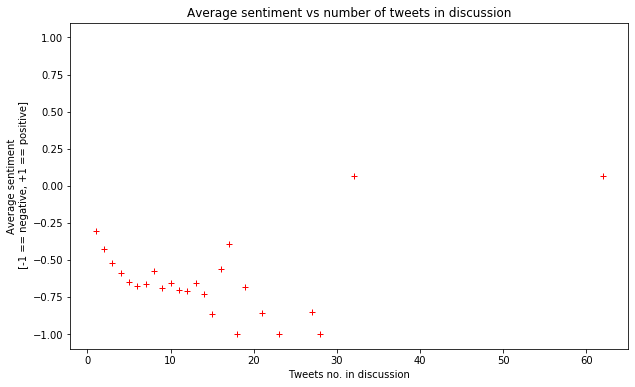

In [15]:
plot_boundaries = tmp['tweets_in_discussion'].unique()
avg_sentiment = []

for item in plot_boundaries:
    tmp_chunk = tmp[tmp['tweets_in_discussion'] == item]
    avg_sentiment.append(tmp_chunk['avg_airline_sentiment'].mean())

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(plot_boundaries, avg_sentiment, '+r')
ax.set(xlabel='Tweets no. in discussion', ylabel='Average sentiment\n [-1 == negative, +1 == positive]',
       title='Average sentiment vs number of tweets in discussion')
ax.set_ylim(-1.1, 1.1)
plt.show()



As we can see the more tweets user has published the more negative sentiment is.  
Of course there are some neutral examples but its probably caused by small smaples amount or by resolving the problem by the airline company.
However it looks like the discussion about the problem is only making everything worse. 
**Actually we cannot use tweets number in a discussion as a feature when we process only one tweet at the time - we have to skip it**

In [16]:
df['retweet_count'].nunique()

18

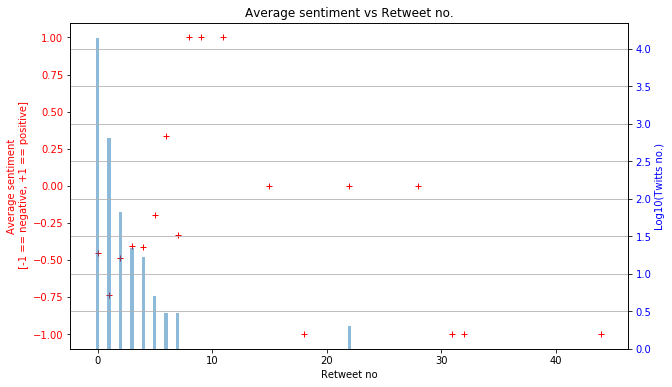

In [17]:
avg_sentiment = []
retweet_counts = df['retweet_count'].unique()
for retweet_count in retweet_counts:
    tmp_chunk = df[df['retweet_count'] == retweet_count]
    avg_sentiment.append(tmp_chunk['airline_sentiment'].mean())

simple_df = pd.DataFrame({'retweet_counts': retweet_counts, 'avg_sentiment': avg_sentiment}).set_index('retweet_counts', drop=True)
simple_df['retweet_log_count'] = df.groupby(['retweet_count']).count().max(axis=1).apply(np.log10)
simple_df = simple_df.sort_index().reset_index()

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(simple_df.retweet_counts, simple_df.avg_sentiment, '+r')
ax1.set(xlabel='Retweet no', title='Average sentiment vs Retweet no.')
ax1.set_ylabel('Average sentiment\n [-1 == negative, +1 == positive]', color='red')  

ax1.tick_params(axis='y', labelcolor='red')
ax1.set_ylim(-1.1, 1.1)

ax2 = ax1.twinx()
ax2.bar(simple_df.retweet_counts, simple_df.retweet_log_count, alpha=0.5, width=0.3)
ax2.set_ylabel('Log10(Twitts no.)', color='blue')  
ax2.tick_params(axis='y', labelcolor='blue')
plt.grid()
plt.show()

On the above plot we can see that most tweets have up to 2 retweets. In fact if we'll look closer at the tweets with up to 10 retweets we can see that if there was only one retweet the sentiment is less by c.a. 0.25 pt. compared to the other ones.

Also, it's clear that positive sentiments aren't so viral as the negative ones - positive ones has only up to 15 retweets, when the opposite have even up to 45.  
Fortunately viral tweets are quite rare so we don't need to bother.

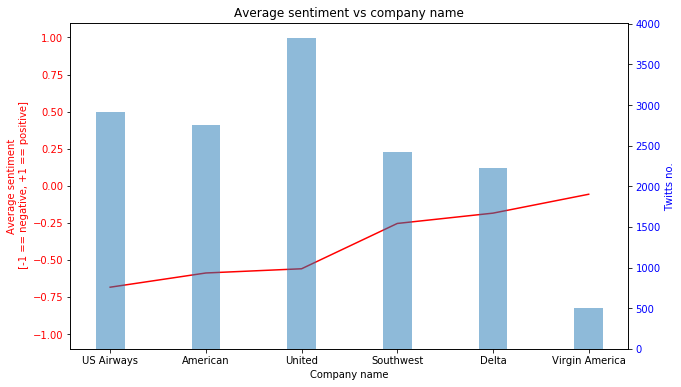

In [18]:
avg_sentiment = []
customer_twitts_no = []
airline_names = df['airline'].unique()
for airline in airline_names:
    tmp_chunk = df[df['airline'] == airline]
    avg_sentiment.append(tmp_chunk['airline_sentiment'].mean())
    customer_twitts_no.append(len(tmp_chunk.index))

simple_df = pd.DataFrame({'avg_sentiment': avg_sentiment, 'customer_twitts_no': customer_twitts_no, 'airline_names': airline_names}).sort_values(by=['avg_sentiment'])

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(simple_df.airline_names, simple_df.avg_sentiment, '-r')
ax1.set(xlabel='Company name', title='Average sentiment vs company name')
ax1.set_ylabel('Average sentiment\n [-1 == negative, +1 == positive]', color='red')  
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_ylim(-1.1, 1.1)

ax2 = ax1.twinx()
ax2.bar(simple_df.airline_names, simple_df.customer_twitts_no, alpha=0.5, width=0.3)
ax2.set_ylabel('Twitts no.', color='blue')  
ax2.tick_params(axis='y', labelcolor='blue')

plt.show()

It's clear that there is quite big difference between the best and worst airlines (around -0.05 compared to the -0.68) but the Virgin America has very small amount of samples (around 500) so we cannot be sure if is this caused by better service quality or not.

However the difference between Southwest or Delta and US Airways or American definitely tells that the latter have worse service qualtiy.

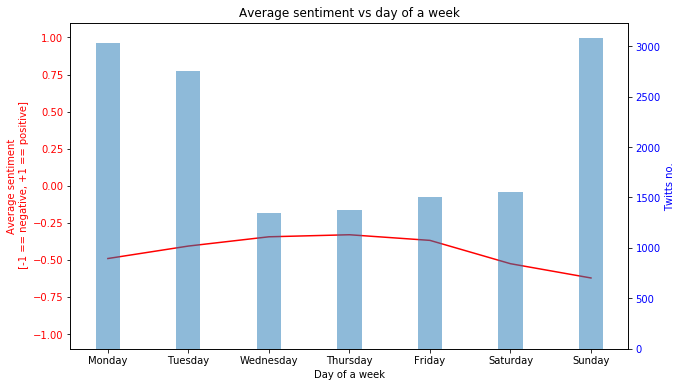

In [19]:
tmp = df.copy()
tmp['week_day'] = pd.to_datetime(tmp['tweet_created']).dt.dayofweek

weekday_twitts_no = []
avg_sentiment = []
days = list(range(7))
for day in days:
    tmp_chunk = tmp[tmp['week_day'] == day]
    avg_sentiment.append(tmp_chunk['airline_sentiment'].mean())
    weekday_twitts_no.append(len(tmp_chunk.index))

simple_df = pd.DataFrame({'avg_sentiment': avg_sentiment, 'weekday_twitts_no': weekday_twitts_no, 'days': days}).sort_values(by=['days'])
simple_df['days'] = simple_df.days.replace(dict(list(zip(days, [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']))))
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(simple_df.days, simple_df.avg_sentiment, '-r')
ax1.set(xlabel='Day of a week', title='Average sentiment vs day of a week')
ax1.set_ylabel('Average sentiment\n [-1 == negative, +1 == positive]', color='red')  

ax1.tick_params(axis='y', labelcolor='red')
ax1.set_ylim(-1.1, 1.1)

ax2 = ax1.twinx()
ax2.bar(simple_df.days, simple_df.weekday_twitts_no, alpha=0.5, width=0.3)
ax2.set_ylabel('Twitts no.', color='blue')  
ax2.tick_params(axis='y', labelcolor='blue')
plt.show()

You can see here that people are less active (and more positive) in the middle of a week while at the Sunday, Monday, and Tuesday they are 2x more active. This rise of activity can be caused by some weekend trips and reviewing quality of air companies services.

# Summary

Even before we start looking closer to the tweet texts itself we already know something. Here is a short summary of what can be useful for use.

1. We will use following list of features:
   ```
   ['retweet_count', 'text', 'tweet_created']
   ```
2. Our target will be:   
   `['airline_sentiment']`
3. We can add features measuring the number of tweets in discussion using one-hot encoding (like from 1 up to 10 and more - so ten clasess)
4. We can do the same with retweets number (like from 0 up to 6 and more]
5. We could use comapny name as a feature but I wonder if it is a good feature because in the real case scenario using company name is some bias to this problem - we would assume a priori that some comapnies are more prone to have low qualite services. So we will skip `Airline` column because we want our algorithm to be airline independent.
6. Using user `name` is also pointless because we will be processing only one tweet at the time so we are unable to find out how many there are tweets in the discussion.
6. We could use day of a week as a feature.

**The next step is to look closer to the tweet textes.**